# Multi Agent Structures (2)

- Author: [Sungchul Kim](https://github.com/rlatjcj)
- Design:
- Peer Review:
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/17-LangGraph/02-Structures/09-LangGraph-Multi-Agent-Structures-02.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/17-LangGraph/02-Structures/09-LangGraph-Multi-Agent-Structures-02.ipynb)

## Overview

In this tutorial, we will explore the existing **supervisor with tool-calling** , **hierarchical** , and **custom multi-agent workflow** structures, following [the previous tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/17-LangGraph/02-Structures/08-LangGraph-Multi-Agent-Structures-01.ipynb).

<div align="center">
  <img src="./assets/09-langgraph-multi-agent-structures-02.png"/>
</div>

- **Supervisor (tool-calling)** : this is a special case of supervisor architecture. Individual agents can be represented as tools. In this case, a supervisor agent uses a tool-calling LLM to decide which of the agent tools to call, as well as the arguments to pass to those agents.

- **Hierarchical** : you can define a multi-agent system with a supervisor of supervisors. This is a generalization of the supervisor architecture and allows for more complex control flows.

- **Custom multi-agent workflow** : each agent communicates with only a subset of agents. Parts of the flow are deterministic, and only some agents can decide which other agents to call next.

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Supervisor Structure with Tool-Calling](#supervisor-structure-with-tool-calling)
- [Hierarchical Structure](#hierarchical-structure)
- [Custom Multi-Agent Workflow](#custom-multi-agent-workflow)

### References

- [LangGraph: Multi-Agent Architectures](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#multi-agent-architectures)

----

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "python-dotenv",
        "langchain_core",
        "langchain-openai",
        "langgraph",
    ],
    verbose=False,
    upgrade=False,
)


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "TAVILY_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "Multi-Agent-Structures-02",
    }
)

Environment variables have been set successfully.


You can alternatively set API keys such as `OPENAI_API_KEY` in a `.env` file and load them.

[Note] This is not necessary if you've already set the required API keys in previous steps.

In [4]:
# Load API keys from .env file
from dotenv import load_dotenv

load_dotenv(override=True)

True

## Supervisor Structure with Tool-Calling

In this variant of the supervisor architecture, we define individual agents as tools and use a tool-calling LLM in the supervisor node. This can be implemented as a ReAct-style agent with two nodes — an LLM node (supervisor) and a tool-calling node that executes tools (agents in this case).

In [5]:
from typing import Annotated
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import InjectedState, create_react_agent

model = ChatOpenAI()

def agent_1(state: Annotated[dict, InjectedState]):
    """
    This is the agent function that will be called as tool.
    You can pass the state to the tool via InjectedState annotation.
    
    NOTE:
    - To use this agent as a tool, you need to write the accurate docstring describing how this agent works.
    """
    
    # you can pass relevant parts of the state to the LLM (e.g., state["messages"])
    # and add any additional logic (different models, custom prompts, structured output, etc.)
    response = model.invoke(...)
    # return the LLM response as a string (expected tool response format)
    # this will be automatically turned to ToolMessage
    # by the prebuilt create_react_agent (supervisor)
    return response.content

def agent_2(state: Annotated[dict, InjectedState]):
    """
    This is the agent function that will be called as tool.
    You can pass the state to the tool via InjectedState annotation.
    
    NOTE:
    - To use this agent as a tool, you need to write the accurate docstring describing how this agent works.
    """
    response = model.invoke(...)
    return response.content

tools = [agent_1, agent_2]
# the simplest way to build a supervisor w/ tool-calling is to use prebuilt ReAct agent graph
# that consists of a tool-calling LLM node (i.e. supervisor) and a tool-executing node
supervisor = create_react_agent(model, tools)

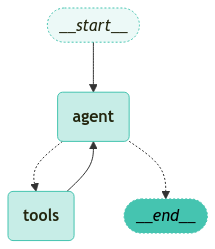

In [6]:
from langchain_opentutorial.graphs import visualize_graph

visualize_graph(supervisor)

## Hierarchical Structure

As you add more agents to your system, it might become too hard for the supervisor to manage all of them. The supervisor might start making poor decisions about which agent to call next, the context might become too complex for a single supervisor to keep track of. In other words, you end up with the same problems that motivated the multi-agent architecture in the first place.

To address this, you can design your system **hierarchically** . For example, you can create separate, specialized teams of agents managed by individual supervisors, and a top-level supervisor to manage the teams.

In [7]:
from typing import Literal
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
model = ChatOpenAI()

# define team 1 (same as the single supervisor example above)

def team_1_supervisor(state: MessagesState) -> Command[Literal["team_1_agent_1", "team_1_agent_2", END]]:
    response = model.invoke(...)
    return Command(goto=response["next_agent"])

def team_1_agent_1(state: MessagesState) -> Command[Literal["team_1_supervisor"]]:
    response = model.invoke(...)
    return Command(goto="team_1_supervisor", update={"messages": [response]})

def team_1_agent_2(state: MessagesState) -> Command[Literal["team_1_supervisor"]]:
    response = model.invoke(...)
    return Command(goto="team_1_supervisor", update={"messages": [response]})

team_1_builder = StateGraph(Team1State := MessagesState)
team_1_builder.add_node(team_1_supervisor)
team_1_builder.add_node(team_1_agent_1)
team_1_builder.add_node(team_1_agent_2)
team_1_builder.add_edge(START, "team_1_supervisor")
team_1_graph = team_1_builder.compile()

# define team 2 (same as the single supervisor example above)
class Team2State(MessagesState):
    next: Literal["team_2_agent_1", "team_2_agent_2", "__end__"]

def team_2_supervisor(state: MessagesState) -> Command[Literal["team_2_agent_1", "team_2_agent_2", END]]:
    response = model.invoke(...)
    return Command(goto=response["next_agent"])

def team_2_agent_1(state: MessagesState) -> Command[Literal["team_2_supervisor"]]:
    response = model.invoke(...)
    return Command(goto="team_2_supervisor", update={"messages": [response]})

def team_2_agent_2(state: MessagesState) -> Command[Literal["team_2_supervisor"]]:
    response = model.invoke(...)
    return Command(goto="team_2_supervisor", update={"messages": [response]})

team_2_builder = StateGraph(Team2State)
team_2_builder.add_node(team_2_supervisor)
team_2_builder.add_node(team_2_agent_1)
team_2_builder.add_node(team_2_agent_2)
team_2_builder.add_edge(START, "team_2_supervisor")
team_2_graph = team_2_builder.compile()


# define top-level supervisor

builder = StateGraph(MessagesState)
def top_level_supervisor(state: MessagesState) -> Command[Literal["team_1_graph", "team_2_graph", END]]:
    # you can pass relevant parts of the state to the LLM (e.g., state["messages"])
    # to determine which team to call next. a common pattern is to call the model
    # with a structured output (e.g. force it to return an output with a "next_team" field)
    response = model.invoke(...)
    # route to one of the teams or exit based on the supervisor's decision
    # if the supervisor returns "__end__", the graph will finish execution
    return Command(goto=response["next_team"])

builder = StateGraph(MessagesState)
builder.add_node(top_level_supervisor)
builder.add_node("team_1_graph", team_1_graph)
builder.add_node("team_2_graph", team_2_graph)
builder.add_edge(START, "top_level_supervisor")
builder.add_edge("team_1_graph", "top_level_supervisor")
builder.add_edge("team_2_graph", "top_level_supervisor")
graph = builder.compile()

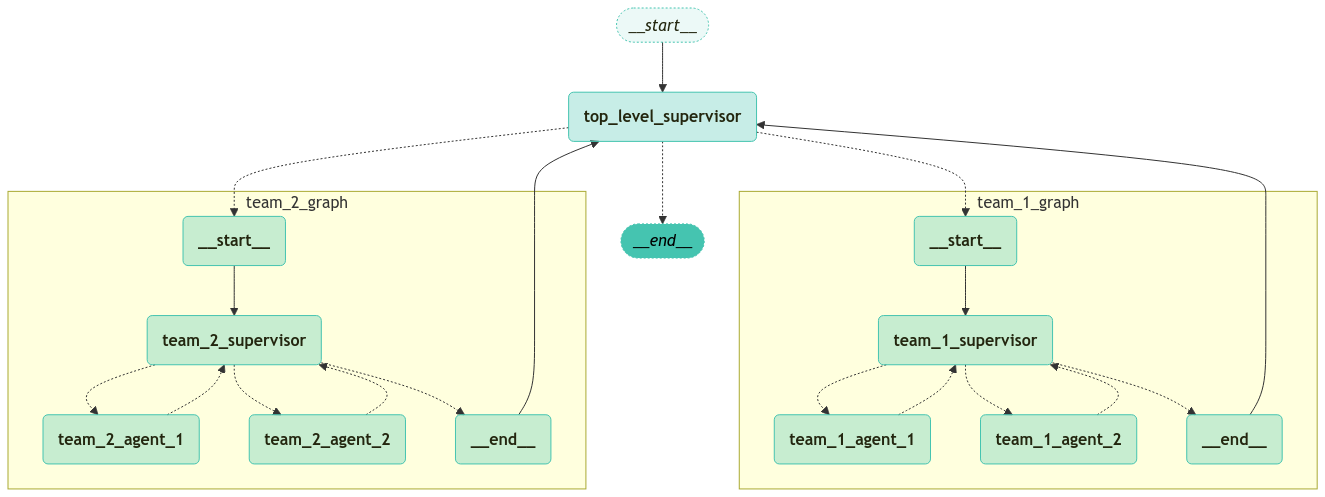

In [8]:
visualize_graph(graph, xray=True)

## Custom Multi-Agent Workflow

In this architecture we add individual agents as graph nodes and define the order in which agents are called ahead of time, in a custom workflow. In `LangGraph` the workflow can be defined in two ways: **Explicit control flow (normal edges)** , **Dynamic control flow (`Command`)** .

### Explicit control flow using normal edges

`LangGraph` allows you to explicitly define the control flow of your application (i.e. the sequence of how agents communicate) explicitly, via normal graph edges. This is the most deterministic variant of this architecture above — we always know which agent will be called next ahead of time.

In [9]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState, START

model = ChatOpenAI()

def agent_1(state: MessagesState):
    response = model.invoke(...)
    return {"messages": [response]}

def agent_2(state: MessagesState):
    response = model.invoke(...)
    return {"messages": [response]}

builder = StateGraph(MessagesState)
builder.add_node(agent_1)
builder.add_node(agent_2)
# define the flow explicitly
builder.add_edge(START, "agent_1")
builder.add_edge("agent_1", "agent_2")
graph = builder.compile()

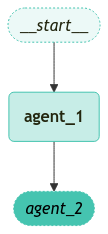

In [10]:
visualize_graph(graph)

### Dynamic control flow using `Command`

In `LangGraph` you can allow LLMs to decide parts of your application control flow. This can be achieved by using `Command` . A special case of this is a supervisor tool-calling architecture. In that case, the tool-calling LLM powering the supervisor agent will make decisions about the order in which the tools (agents) are being called.

In [11]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition


@tool
def tool_1(message: str) -> str:
    """This is tool_1."""
    return "Hello, tool_1."

@tool
def tool_2(message: str) -> str:
    """This is tool_2."""
    return "Hello, tool_2."

tools = [tool_1, tool_2]
tool_node = ToolNode(tools)

model = ChatOpenAI()

workflow = StateGraph(MessagesState)
workflow.add_node("tools", tool_node)
workflow.add_node("model", model)
workflow.add_edge(START, "model")
workflow.add_edge("tools", "model")
workflow.add_conditional_edges("model", tools_condition)

graph = workflow.compile()

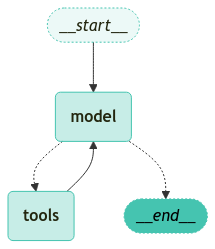

In [12]:
visualize_graph(graph)